In this notebook I'm generating the simulated data to compare to real data. 

In [57]:
using CSV, StatsBase, Distributions,DataFrames,PythonPlot,DifferentialEquations,LinearAlgebra
include("./../simulation_models.jl")

data = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);
lineages = unique(data.lineage);

# OU model

In [58]:
# generate data
λ0 = 0.05
init = [40,λ0,80,0]
σ_gr = sqrt(1.32e-7)
τ = 10
D = σ_gr^2/τ
σDS = 0.001

Δ = 40
σM = sqrt(40)
θ = [Δ,σDS,τ,λ0,D,σM] 
prob,callback = build_model(θ,init,(0,10000))
sol = solve(prob,callback = callback)
u = hcat(sol.u...)';

# put in dataframe
df = DataFrame(u,["M","λ","Mf","position"])
df[:,"time"] = sol.t;
positions = unique(df.position)
df[:,:age] = vcat([df[df.position .==p,:time] .- df[df.position .==p,:time][1] 
for p in positions]...)
df[:,:age_normed] = vcat([df[df.position .==p,:age]./df[df.position .==p,:age][end] 
for p in positions]...);
df[:,:age_rounded] = round.(df[:,:age_normed],digits=1);
df

df_cells = combine(groupby(df,:position),:λ=>mean=>:gr,:M=>(x->x[1])=>:M0,:time=>(x->x[end]-x[1])=>:gt)
df_cells[df_cells.gt .> 0,:]

Row,position,gr,M0,gt
,Float64,Float64,Float64,Float64
1,0.0,0.0498656,40.0,13.9012
2,1.0,0.0494762,40.0,14.5515
3,2.0,0.0509797,41.0843,11.1889
4,3.0,0.0493262,36.3381,13.2686
5,4.0,0.0506906,34.9603,15.8751
6,5.0,0.05092,39.0875,16.5857
7,6.0,0.0498353,45.4761,13.0776
8,7.0,0.0510071,43.6302,11.9001
9,8.0,0.0499369,40.0285,14.9437


In [1]:
fig, ax = subplots(figsize=(10,2))
ax2 = ax.twinx()
for p in unique(df.position)[1:10]
    dfp = df[df.position .== p,:]
    ax.plot(dfp.time,dfp.M,"k-")
    ax2.plot(dfp.time,dfp.λ,"r-")
end
fig

UndefVarError: UndefVarError: `subplots` not defined

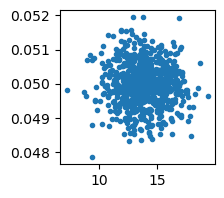

In [56]:
fig, ax = subplots(figsize=(2,2))
df_cells = df_cells[df_cells.gt .>0,:]
#ax.plot(df_cells.gr,df_cells.gt,".")
ax.plot(df_cells.gt,df_cells.gr,".")
fig


In [206]:
df[df.position .== 5,:].time

234-element Vector{Float64}:
 68.5904312478899
 68.64943729472165
 68.70878964033466
 68.7681315696393
 68.82756127168368
 68.8870550563542
 68.94662041036962
 69.00626721214499
 69.06595422564986
 69.12568873243721
  ⋮
 82.08635854043627
 82.14608307267946
 82.20577968131356
 82.26542269924379
 82.32504212731943
 82.38466648201477
 82.44426221679608
 82.50384926760935
 82.54815101503506

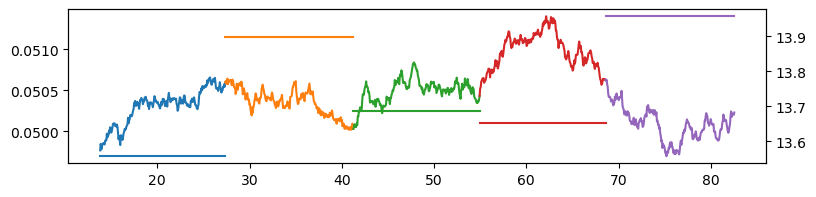

In [207]:
fig, ax = subplots(figsize=(9,2))
ax2 = ax.twinx()
for p in 1:5
    ax.plot(df[df.position .== p,:].time,df[df.position.== p,:].λ)
    ax2.plot(df[df.position .== p,:].time,ones(length(df[df.position .== p,:].time))*
    df_cells[df_cells.position .== p,:].gt[1],"-")
end

fig


In [208]:
df[df.position .== 32,:].time

Float64[]

# Chemical reaction model

In [64]:
function F(du, u, p, t)
    # Model parameters.
    α_R,α_Q,α_C = p
    du[1] =  α_R*u[1]
    du[2] =  α_Q*u[1]
    du[3] =  α_C*u[1]
    du[4] = 0.0

    return nothing
end
function G(du,u,p,t)
    α_R,α_Q,α_C = p
    du[1] =  sqrt(α_R*u[1])
    du[2] =  sqrt(α_Q*u[1])
    du[3] =  sqrt(α_C*u[1])
    du[4] =  0.0
end

c_crit = 60
function condition(u, t, integrator) # Event when condition(u,t,integrator) == 0
    c_crit - u[3]
end

function affect!(integrator)
    u = integrator.u
    u[1] = u[1]/2
    u[2] = u[2]/2 
    u[3] = c_crit/2
    u[4] = u[4] + 1
    nothing
end





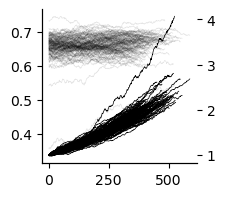

In [65]:
# generate data
init = [50,50,50,0]
θ = [10,2.0,3.0]
prob = SDEProblem(F,G,init,(0,10),θ)
sol = solve(prob,callback = callback)
u = hcat(sol.u...)';

# put in dataframe
df = DataFrame(u,["uR","uQ","uC","position"])
df[:,"time"] = sol.t;
df[:,:y] = df[:,:uR]+df[:,:uQ] + df[:,:uQ];


# plot
fig,ax = subplots(figsize=(2,2),sharex=true)
inds = unique(df[:,:position])
ax2 = ax.twinx()

for pos in inds
    df_cell = df[df.position .== pos,:]
    
    ax2.plot(1:length(df_cell.time),df_cell.uR/df_cell.uR[1],"-",color="k",lw=0.5)
    ax.plot(1:length(df_cell.time),df_cell.uR ./ (df_cell.uR .+ df_cell.uC .+ df_cell.uQ),color="k",lw=0.5,alpha=0.1)
end
ax2.spines["right"].set_visible(false)
ax.spines["right"].set_visible(false)
ax2.spines["top"].set_visible(false)
ax.spines["top"].set_visible(false)
#ax.plot(sol.t,u[:,2])
fig

In [849]:
function loss(p)
    tmp_prob = remake(prob, p = p)
    tmp_sol = solve(tmp_prob, SOSRI(), saveat = 0.1, trajectories = 1000)
    arrsol = Array(tmp_sol)
    sum(abs2, truemean - mean(arrsol, dims = 3)) +
    0.1sum(abs2, truevar - var(arrsol, dims = 3)),
    arrsol
end

function cb2(p, l, arrsol)
    @show p, l
    means = mean(arrsol, dims = 3)[:, :]
    vars = var(arrsol, dims = 3)[:, :]
    p1 = plot(sol[1].t, means', lw = 5)
    scatter!(p1, sol[1].t, truemean')
    p2 = plot(sol[1].t, vars', lw = 5)
    scatter!(p2, sol[1].t, truevar')
    p = plot(p1, p2, layout = (2, 1))
    display(p)
    false
end
